# Tuning the value of K using polarizablity.


#### path = "............" refers to the path of the dump file from which data is to be extracted

#### frames = ------ number of frames during openmd execution

#### atomNumber = ----------- total number of atomic sites during program execution

#### atomPlate= ................ number of atoms in capacitave plates

In [133]:
# extract information from dump file.
import numpy as num
import matplotlib.pyplot as plt
import pylab as lab
from scipy import constants
import scipy as sci
import pandas as pan
import os
from collections import OrderedDict
%matplotlib inline

In [134]:

    
"""
infoDict=DumpExtractor(filename,frames,atomNumber,atomPlate)


Function that extracts the information from the .dump file created by openmd
    
    
    Inputs:
  ===========
   
   
   filename:
   
               Path of the dump file from which the information is to be extracted
               
    frame:
    
                Total number of frames in the dump file
                
    atomNumber:
        
                Totla number of atoms in the slab or crystal
                
    atomPlate:
    
                Total number of atoms in the capacitor plates



    Outputs:
 =============
 
 infoDict:
 
         Dictonary containing position, velocity, chargeQV, electricField, plateEQV.
         Postion is a list of [x,y,z] and each x,y,z are array of x[frames][sites]
         velocity is a list of [vx,vy,vz] and each vx,vy,vz are array of vx[frames][sites]
         chargeQV is a lisf of [c,cv] and each c and cv are array of c[frame][sites]
         electric field is list of [ex,ey,ez] and each are array of ex[frame][sites]
         plateEQV is the list of [pex,pey,pez,pc,pcv] and each are array of pex[frames][sites]
"""
   
def DumpExtractor(filename,frames,atomNumber,atomPlate):
    
    fileDump=open(filename)  #dump file for info extraction
    linesDump=fileDump.readlines()

    processP="Wait"
    processC="Wait"


    #information storage matrix 
    #posiiton and velocity storage
    x=num.zeros((frames,atomNumber+1))
    y=num.zeros((frames,atomNumber+1))
    z=num.zeros((frames,atomNumber+1))
    vx=num.zeros((frames,atomNumber+1))
    vy=num.zeros((frames,atomNumber+1))
    vz=num.zeros((frames,atomNumber+1))


    #charge and velocity storage matrix
    c=num.zeros((frames,atomNumber+1))
    cv=num.zeros((frames,atomNumber+1))
    ex=num.zeros((frames,atomNumber+1))
    ey=num.zeros((frames,atomNumber+1))
    ez=num.zeros((frames,atomNumber+1))
    pc=num.zeros((frames,atomPlate))
    pcv=num.zeros((frames,atomPlate))
    pex=num.zeros((frames,atomPlate))
    pey=num.zeros((frames,atomPlate))
    pez=num.zeros((frames,atomPlate))

    #frame count initilization
    fCount=0
    index=0  #index for the atoms
    for line in linesDump:
        linesSplit=str.split(line)
        length=len(linesSplit)
    
        if(length!=0 and linesSplit[0]=="<StuntDoubles>" and processP=="Wait"):
            processP="Start"
            continue;
        
        elif(length!=0 and linesSplit[0]=="</StuntDoubles>" and processP=="Start"):
            processP="Wait"
            index=0
            continue;
        
        elif(length!=0 and linesSplit[0]=="<SiteData>" and processC=="Wait"):
            processC="Start"
            continue;
        
        elif(length!=0 and linesSplit[0]=="</SiteData>" and processC=="Start"):
            fCount=fCount+1
            index=0;
            processC="Wait"
            continue;
   
        elif(fCount>=frames):
            break;
        
        else:
            processP=processP;
            processC=processC;
        
        
        if (processP=="Start"):
            x[fCount][int(linesSplit[0])]=float(linesSplit[2])
            y[fCount][int(linesSplit[0])]=float(linesSplit[3])
            z[fCount][int(linesSplit[0])]=float(linesSplit[4])
            vx[fCount][int(linesSplit[0])]=float(linesSplit[5])
            vy[fCount][int(linesSplit[0])]=float(linesSplit[6])
            vz[fCount][int(linesSplit[0])]=float(linesSplit[7])
        
        if(processC=="Start"):
            if int(linesSplit[0])<atomNumber:
                c[fCount][int(linesSplit[0])]=float(linesSplit[3])
                cv[fCount][int(linesSplit[0])]=float(linesSplit[4])
                ex[fCount][int(linesSplit[0])]=float(linesSplit[5])
                ey[fCount][int(linesSplit[0])]=float(linesSplit[6])
                ez[fCount][int(linesSplit[0])]=float(linesSplit[7])
            elif (int(linesSplit[0])==atomNumber and linesSplit[1]=="cwe"):
                continue
                c[fCount][int(linesSplit[0])]=float(linesSplit[2])
                cv[fCount][int(linesSplit[0])]=float(linesSplit[3])
                ex[fCount][int(linesSplit[0])]=float(linesSplit[4])
                ey[fCount][int(linesSplit[0])]=float(linesSplit[5])
                ez[fCount][int(linesSplit[0])]=float(linesSplit[6])
            else:
                pc[fCount][int(linesSplit[1])]=float(linesSplit[3])
                pcv[fCount][int(linesSplit[1])]=float(linesSplit[4])
                pex[fCount][int(linesSplit[1])]=float(linesSplit[5])
                pey[fCount][int(linesSplit[1])]=float(linesSplit[6])
                pez[fCount][int(linesSplit[1])]=float(linesSplit[7])
        
    position=[x,y,z]
    velocity=[vx,vy,vz]
    chargeQV=[c,cv]
    electricField=[ex,ey,ez]
    platesEQV=[pex,pey,pez,pc,pcv]
    
    infoDict={"position":position,"velocity":velocity,"chargeQV":chargeQV,"electricField":electricField,"platesEQV":platesEQV}
    return infoDict


In [135]:
"""Function that determines different layers in a crystal

[layer,a]= Layers(ZPosition,atomNumber)
 
  Input:
 ========
 
         ZPosition: Z Coordinates of lattice for layer determination
         
         atomNumber: total Number of atoms in crystal
         
         
  Output:
 =========
         list [layer,a]; layer has index for atoms in each layers and "a" has the z-coordinates for each layers
         
         
"""
def Layers(ZPosition,atomNumber):
    a=num.sort(list(set(ZPosition[0,0:atomNumber-1])))
    layer=[]
    for var in a:
        layer.append(num.where(ZPosition[0]==var))
    
    return [layer,a]

In [136]:
def LayerDipole(dumpFile,frames,atomNumber,atomPlate,UsedFrame,K,E,plotBool):
    try:
        dump=DumpExtractor(dumpFile,frames,atomNumber,atomPlate)
        pos=dump["position"]
        charge=dump["chargeQV"]
        layersInfo=Layers(pos[2],atomNumber)
        layer=layersInfo[0]
        a=layersInfo[1]
        averageChargeLayers=[]
        aveZpos=[]
    
    
        for counter in range(len(a)):
            averageChargeLayers.append(num.sum(charge[0][UsedFrame,layer[counter][0]])/float(len(layer[counter][0])))
            aveZpos.append(num.sum(pos[2][UsedFrame,layer[counter][0]])/float(len(layer[counter][0])))
        diff=[]
        precharge=0
        prez=0
        for counter in range(len(a)):
            diff.append((averageChargeLayers[counter]-precharge)*(aveZpos[counter]-prez))
            precharge=averageChargeLayers[counter]
            prez=aveZpos[counter]
    
        if plotBool==True:
            lab.plot(range(1,len(a)),diff[1:],'o-')
            lab.xlabel("Layers")
            lab.ylabel("LayerDipole")
            lab.title("E = "+str(E)+" || K = "+str(K))
            lab.grid()
            lab.show()
        dipole=num.sum(diff[2:-1])/float(len(diff)-3)
        return dipole
    
    except:
        return 99999

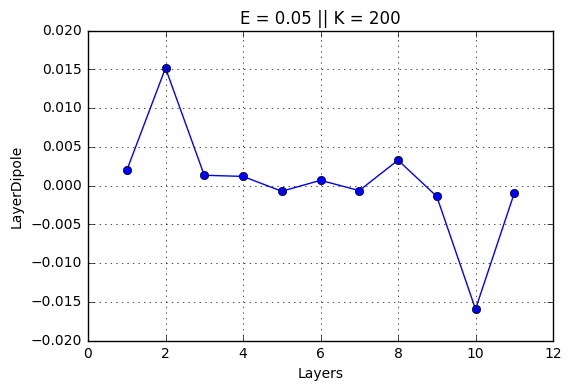

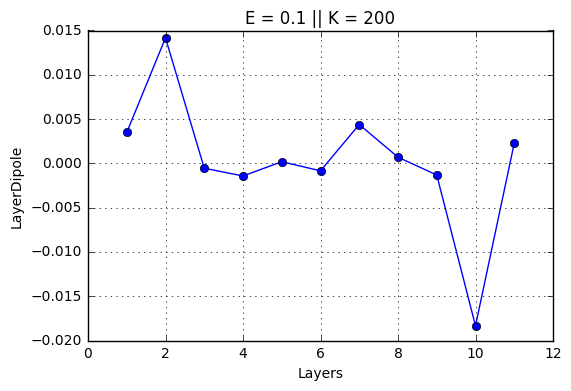

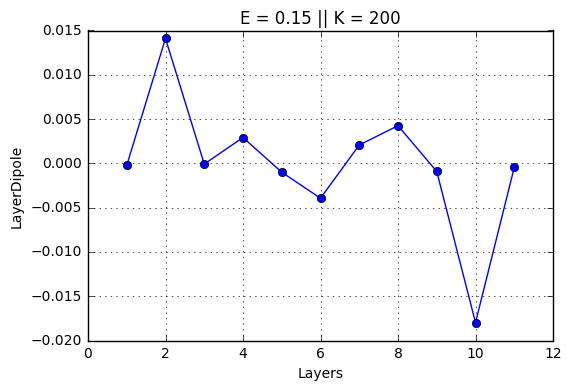

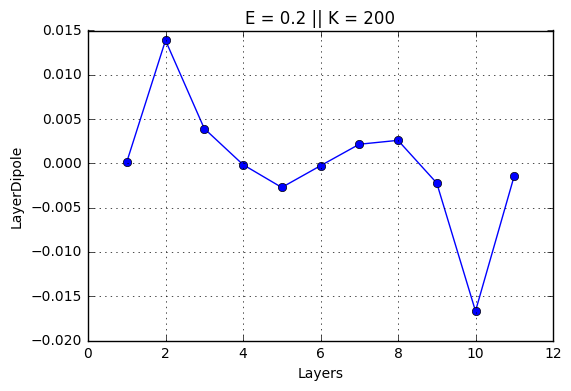

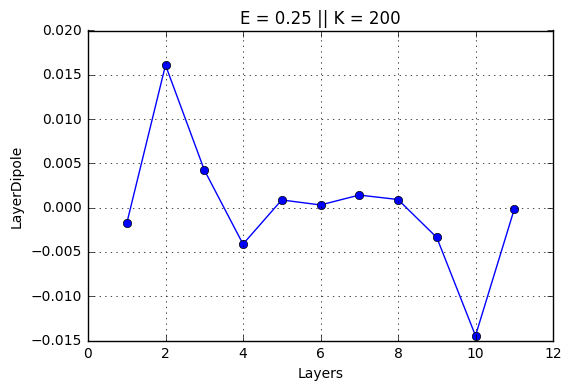

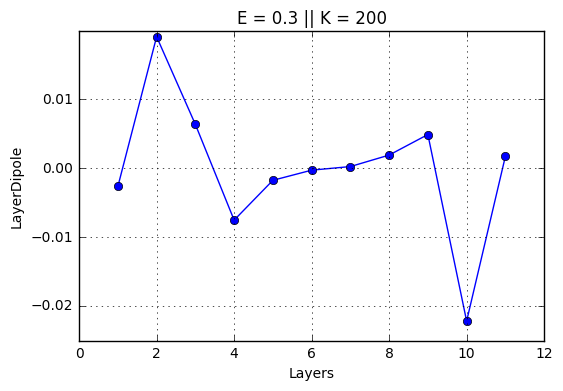

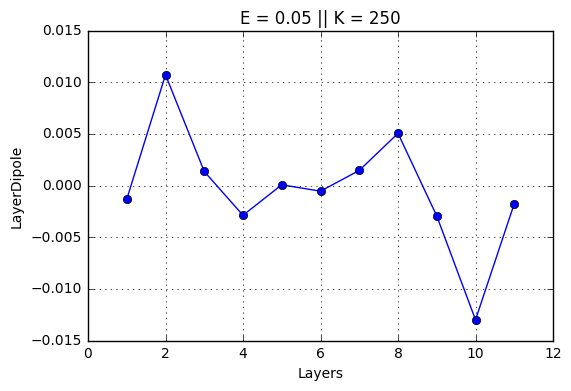

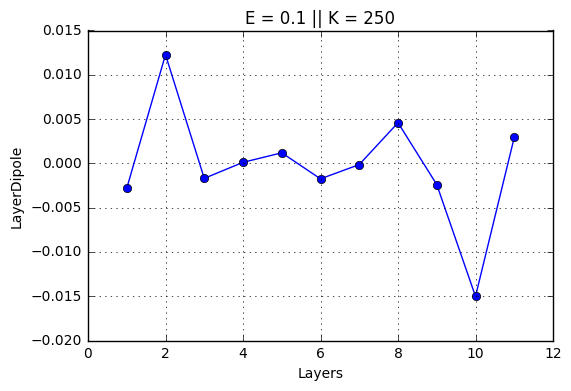

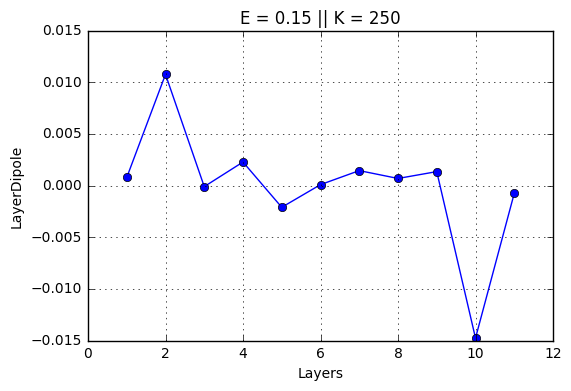

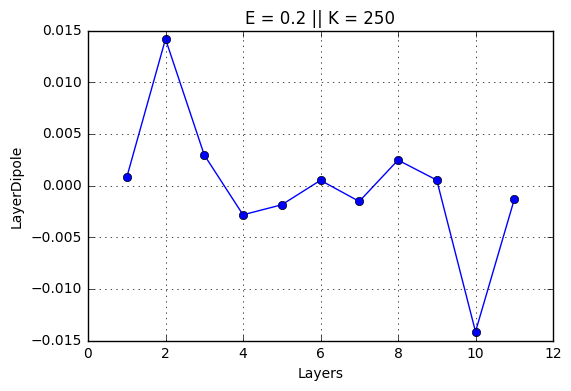

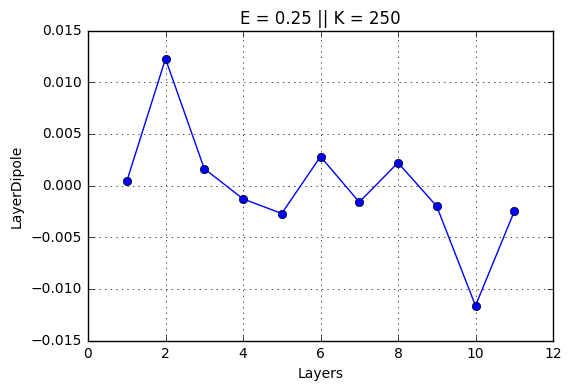

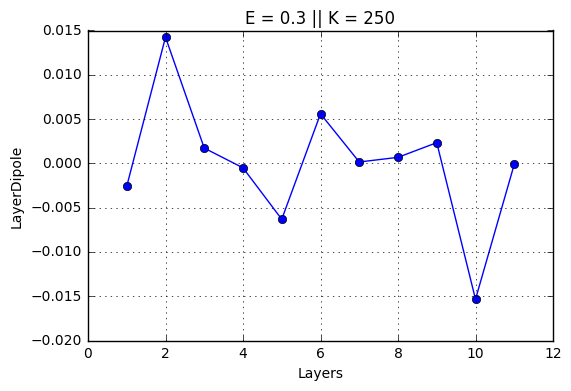

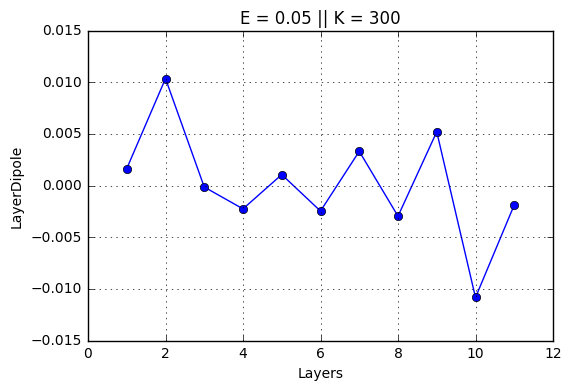

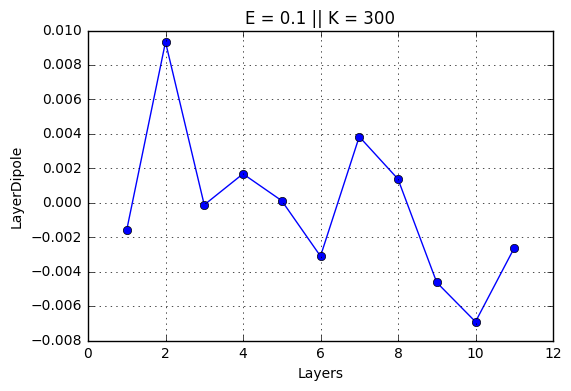

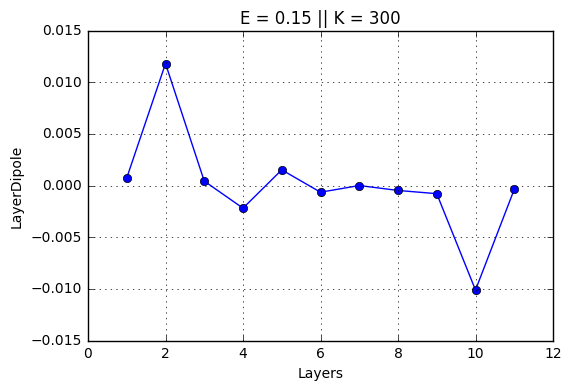

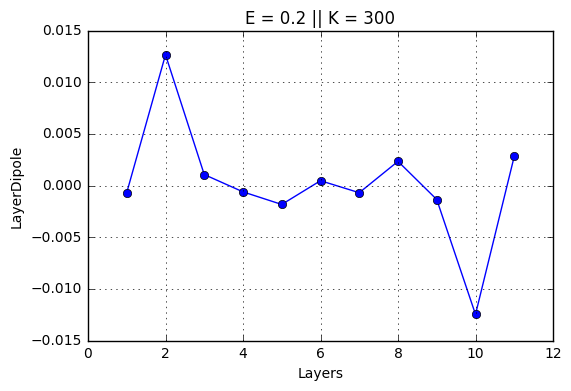

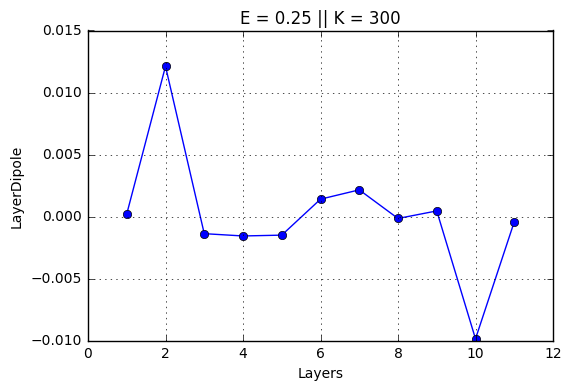

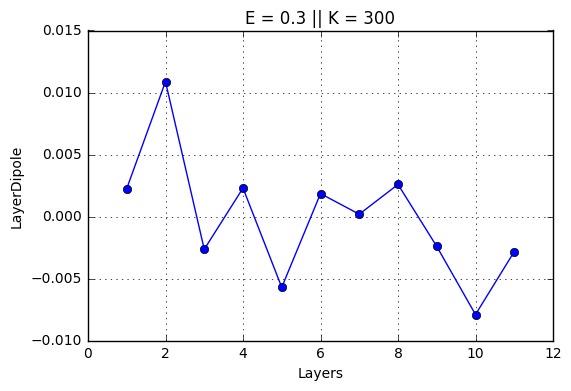

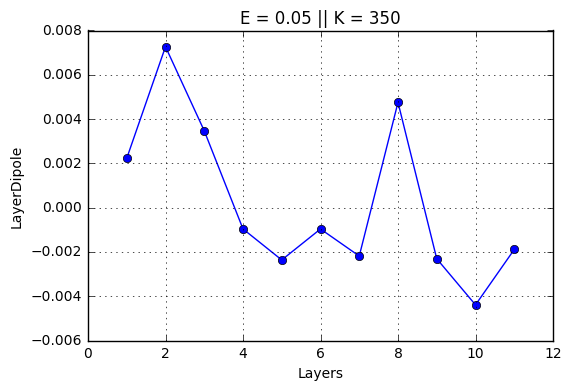

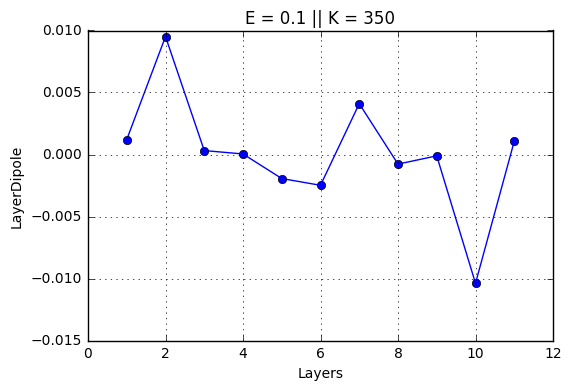

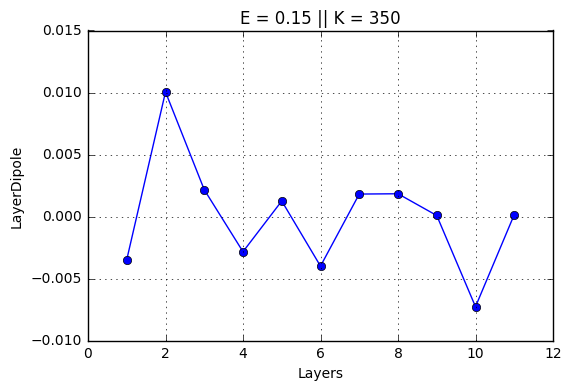

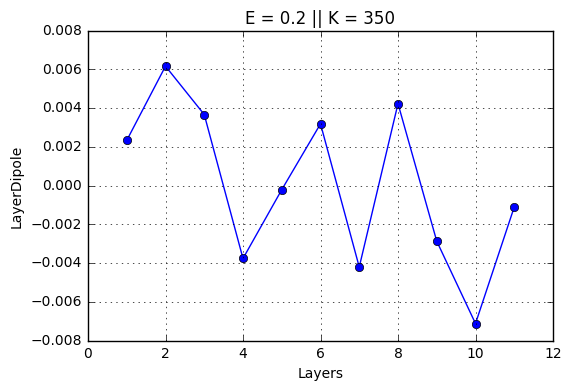

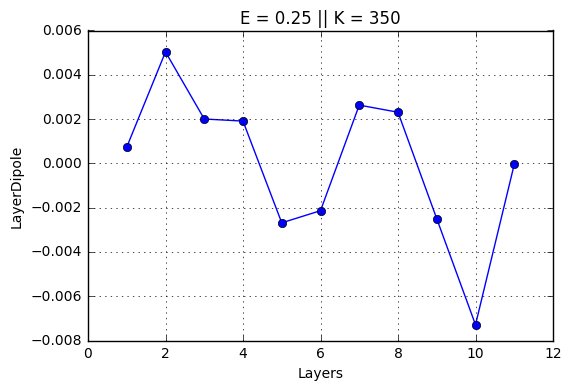

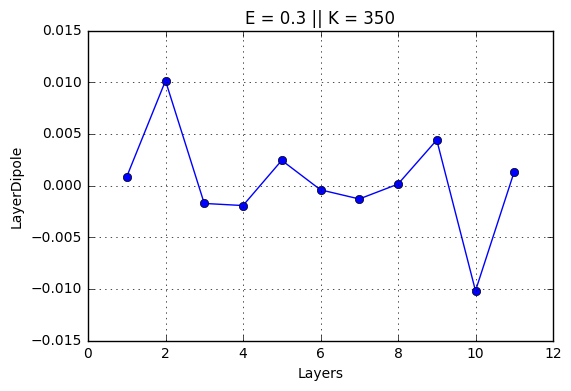

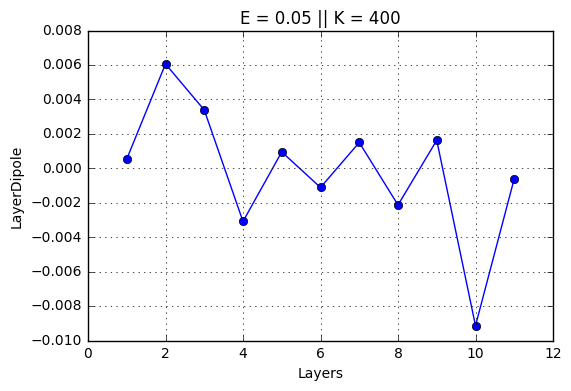

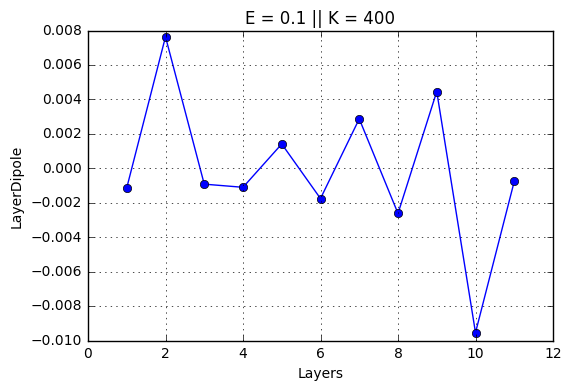

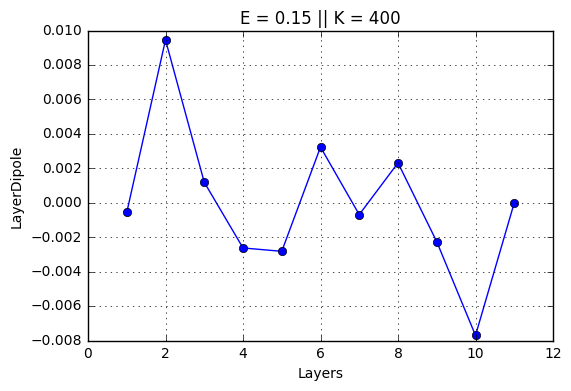

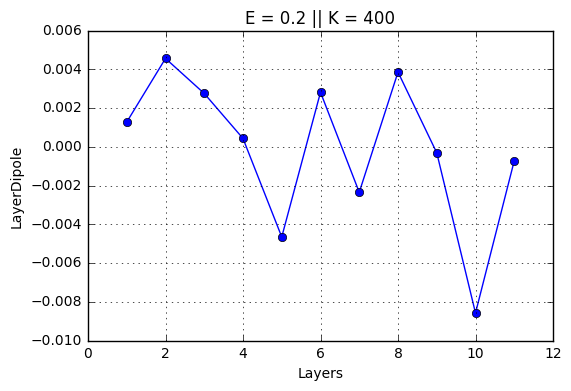

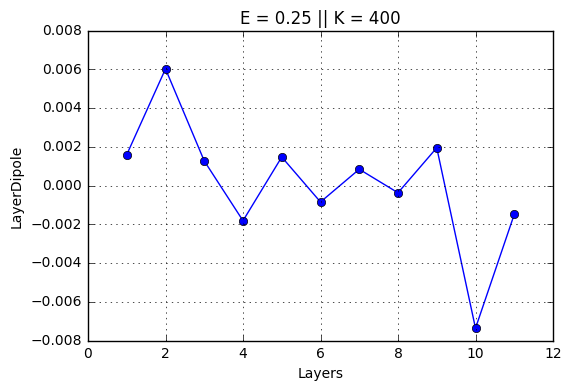

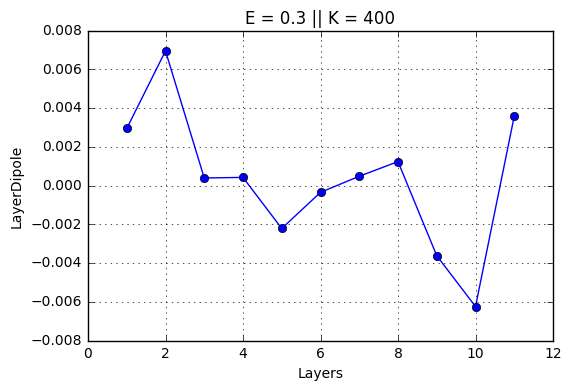

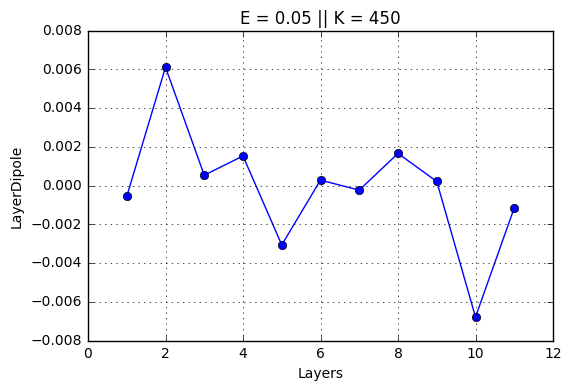

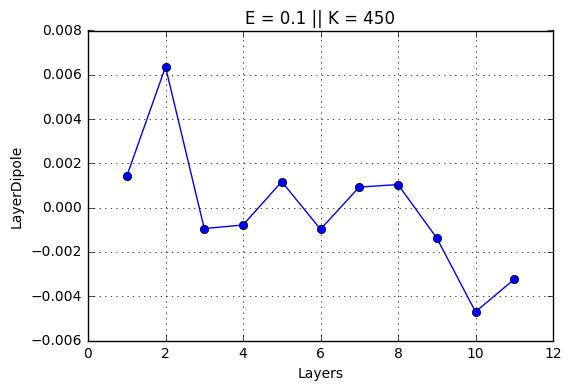

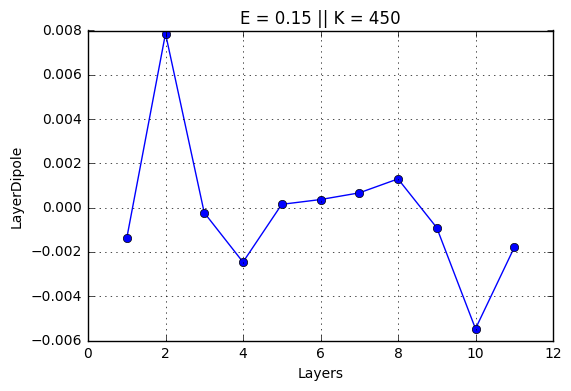

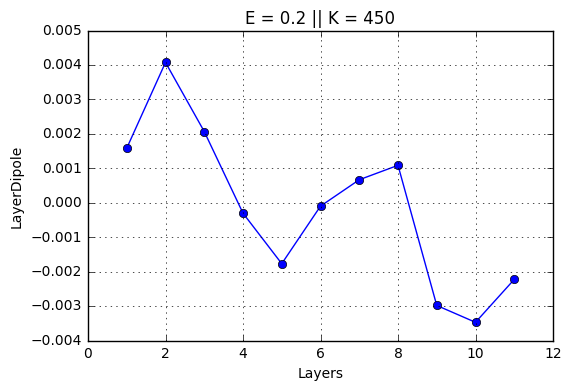

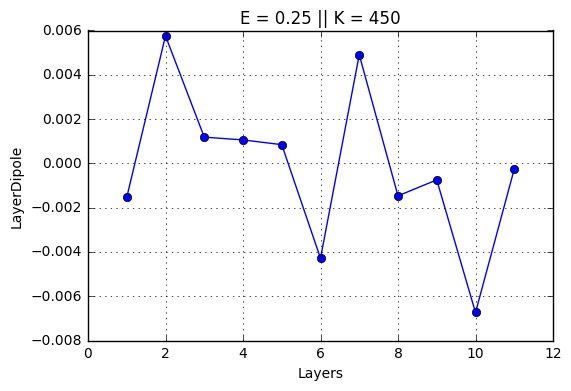

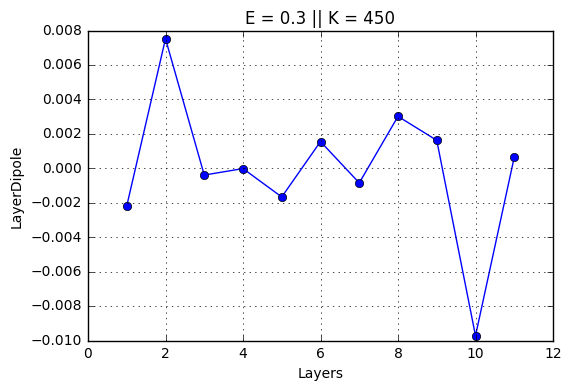

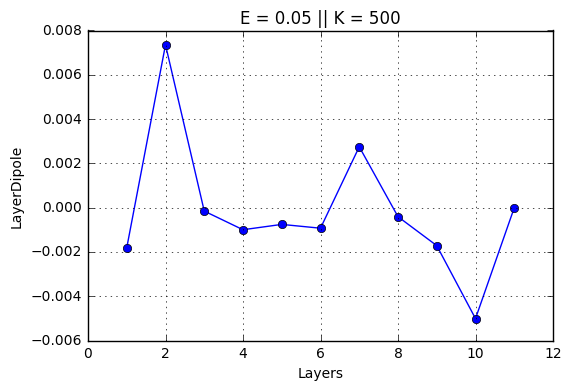

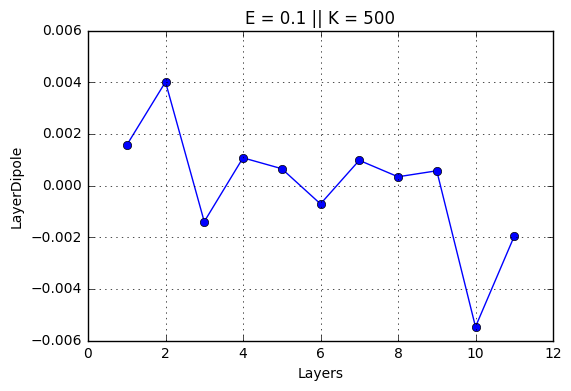

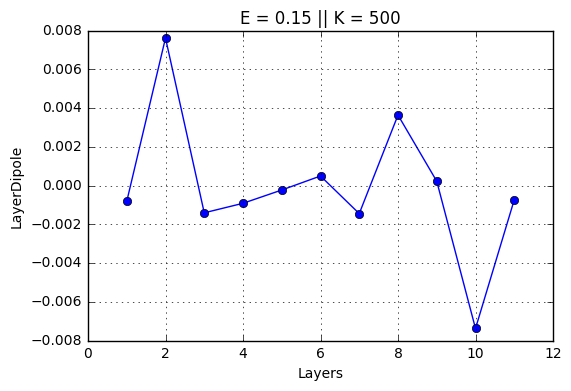

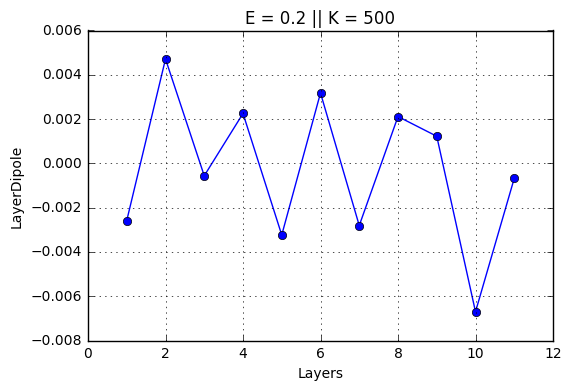

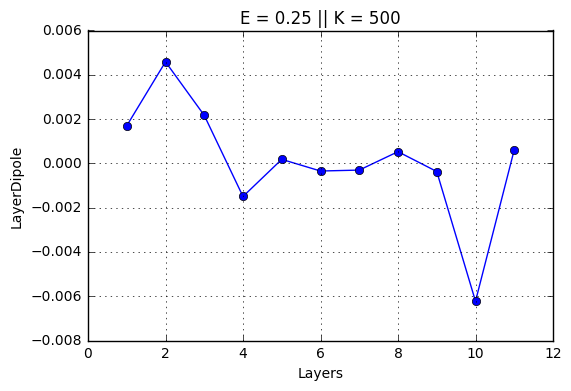

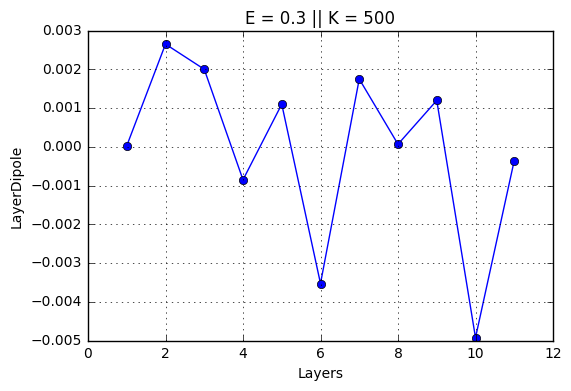

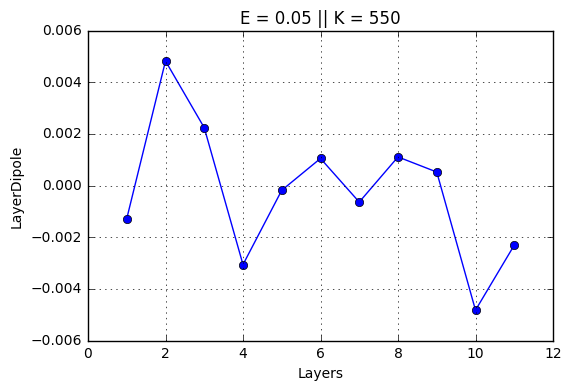

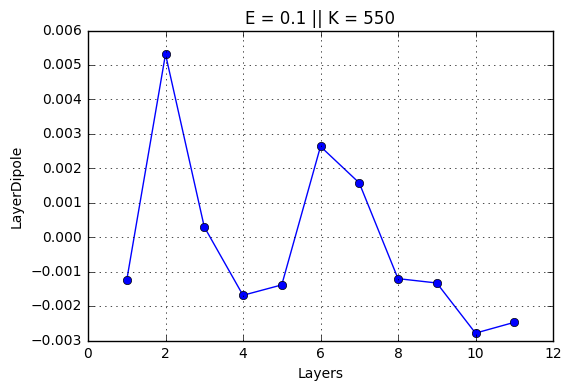

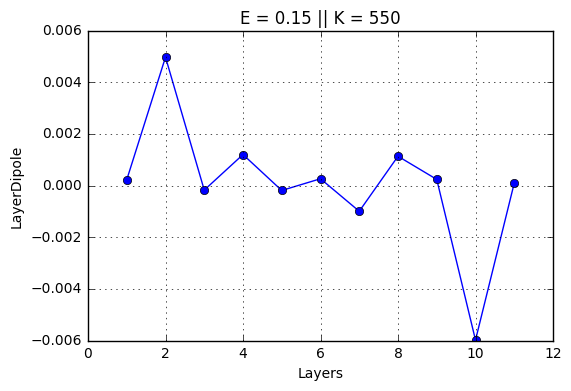

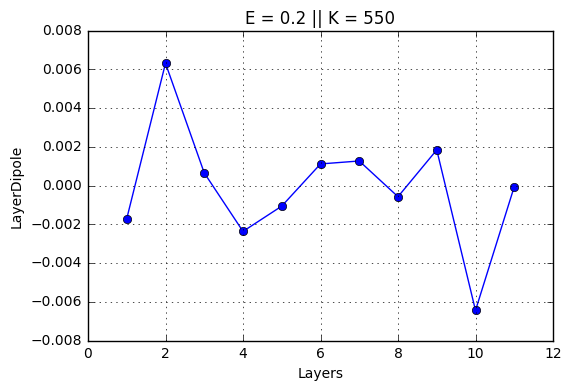

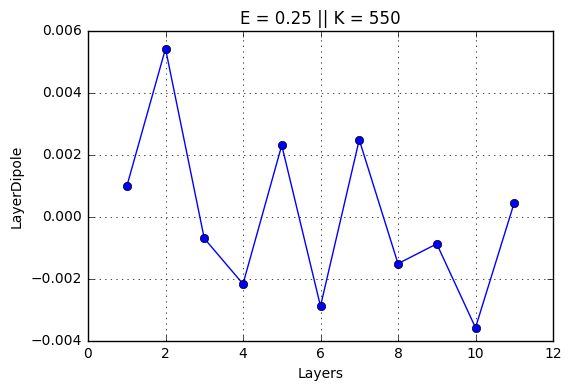

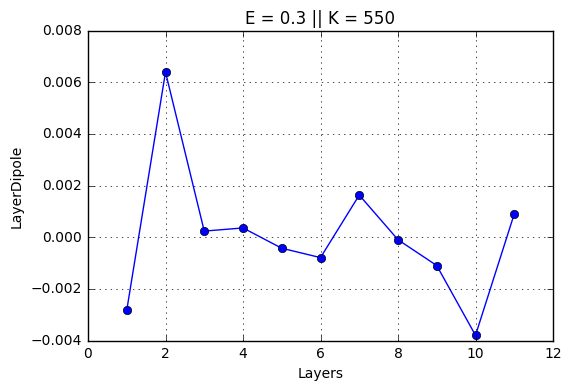

In [144]:
# values of k
k=[200,250,300,350,400,450,500,550]
E=[0.5,1,1.5,2,2.5,3]
frameUsed=99
atomNumber=192
atomPlate=0
frames=100
pathFolder="../Susceptiblity_K_determine/6Layer100Zhou2001/"
plot=True


ke=[[kfile,Efile] for kfile in k for Efile in E]
dipoleMoment=[]
valuesK=[]
valuesE=[]
for fileTag in ke:
    
    filename=("PtSlab100Zhou2001Layers12K_"+str(fileTag[0])+"E_"+str(fileTag[1])+".dump")
    dipoleMoment.append(LayerDipole(pathFolder+filename,frames,atomNumber,atomPlate,frameUsed,fileTag[0],\
                                    fileTag[1]/float(10),plot))
    valuesK.append(fileTag[0])
    valuesE.append(fileTag[1]/float(10))

dipoleDict=OrderedDict([("K",valuesK),("E",valuesE),("Dipole",dipoleMoment)])
dipoleFrame=pan.DataFrame(dipoleDict)

In [145]:
dipoleFrame["Dipole"]=dipoleFrame["Dipole"]*1.6e-19*1e-10
dipoleFrame

,K,E,Dipole
0,200,0.05,5.030003e-33
1,200,0.10,-5.399596e-33
2,200,0.15,-1.019371e-33
3,200,0.20,9.592031e-34
4,200,0.25,3.420135e-33
5,200,0.30,1.414342e-33
6,250,0.05,-1.302834e-33
7,250,0.10,-5.024154e-33
8,250,0.15,-7.271793e-34
9,250,0.20,4.107929e-34


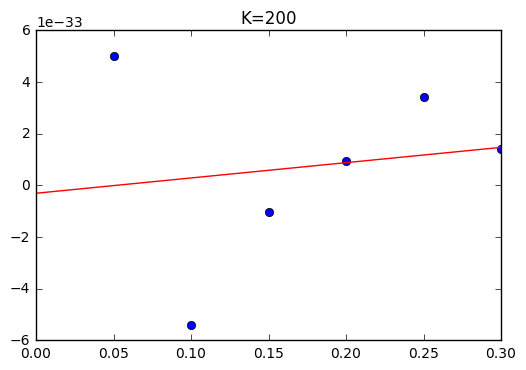

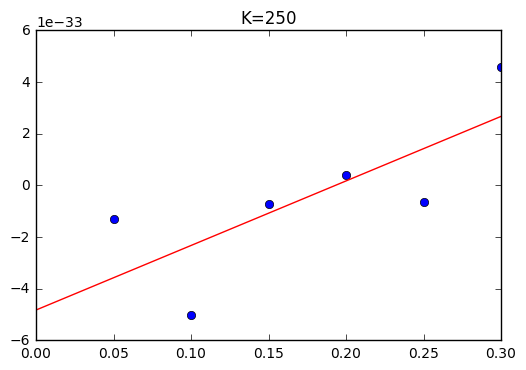

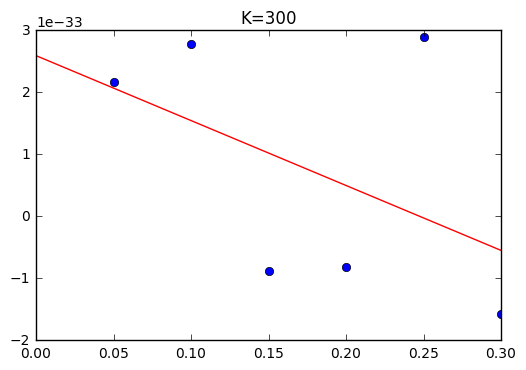

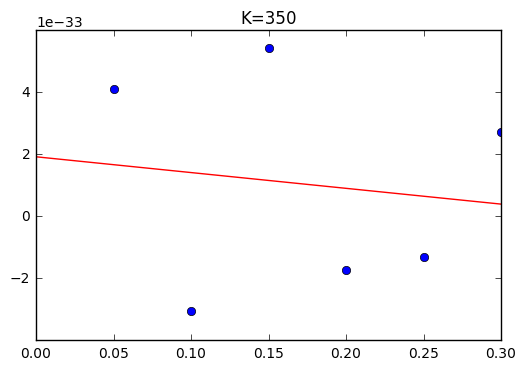

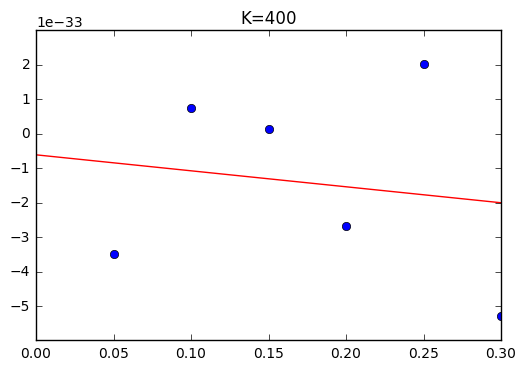

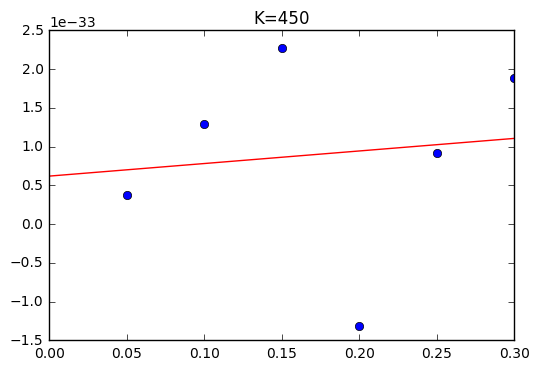

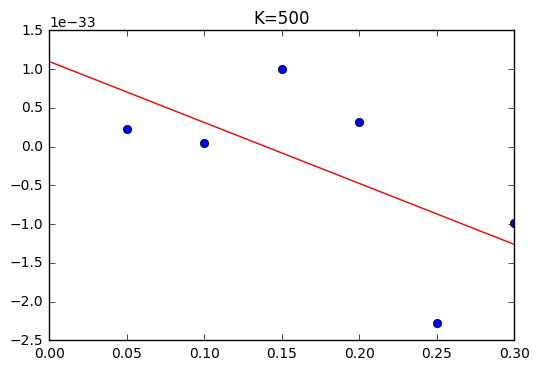

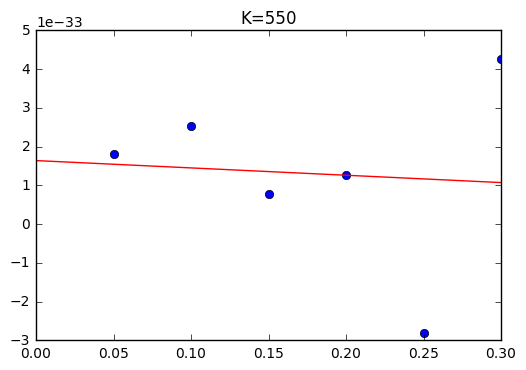

In [146]:
from scipy import stats
newFrame=dipoleFrame[num.logical_and(dipoleFrame.Dipole!=99999,dipoleFrame.E<=0.3)]
slope=[]
intercept=[]
error=[]
for kval in k:
    entries=newFrame.K==kval
    s,i,p_val,r_val,std_err=stats.linregress(newFrame[entries].E,newFrame[entries].Dipole)
    slope.append(s)
    intercept.append(i)
    error.append(std_err)
    lab.plot(newFrame[entries].E,newFrame[entries].Dipole,'bo')
    ee=num.linspace(0,max(newFrame.E),1000)
    lab.plot(ee,s*ee+i,"r")
    lab.title("K="+str(kval))
    lab.show()

In [147]:
dataSloInt=OrderedDict([("K",k),("slope",slope),("intercept",intercept),("error",error)])

In [148]:
dataFrameSIE=pan.DataFrame(dataSloInt)
dataFrameSIE

,K,slope,intercept,error
0,200,5.919692e-33,-3.018269e-34,1.932382e-32
1,250,2.498479e-32,-4.822030e-33,1.082555e-32
2,300,-1.047116e-32,2.593485e-33,9.696702e-33
3,350,-5.088260e-33,1.924323e-33,1.858119e-32
4,400,-4.638294e-33,-6.111040e-34,1.489299e-32
5,450,1.621651e-33,6.206053e-34,6.774598e-33
6,500,-7.865075e-33,1.098232e-33,4.878031e-33
7,550,-1.891850e-33,1.641764e-33,1.253938e-32


In [149]:
dataFrameSIE["Slope800"]=slope
dataFrameSIE["intercept800"]=intercept
dataFrameSIE["error800"]=error

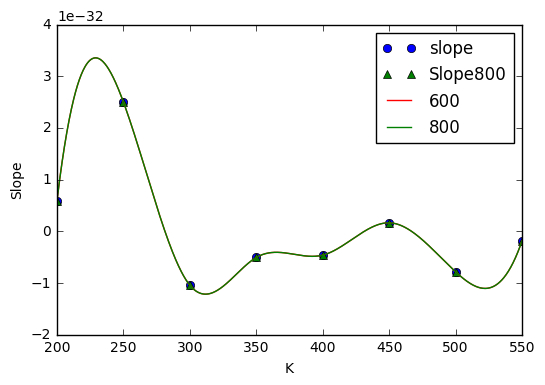

In [150]:
from scipy.interpolate import interp1d
lab.plot(dataFrameSIE.K,dataFrameSIE.slope,"o")
lab.plot(dataFrameSIE.K,dataFrameSIE.Slope800,'^')
fitFx=interp1d(dataFrameSIE.K,dataFrameSIE.slope,kind="cubic")
fitFx800=interp1d(dataFrameSIE.K,dataFrameSIE.Slope800,kind="cubic")
kk=num.linspace(min(dataFrameSIE.K),max(dataFrameSIE.K),1000)
lab.plot(kk,fitFx(kk),"r",label="600")
lab.plot(kk,fitFx800(kk),"g",label='800')
lab.xlabel("K")
lab.legend()
lab.ylabel("Slope")
lab.show()

In [56]:
dataFrameSIE

,K,slope,intercept,error,Slope800,intercept800,error800
0,600,0.217142,-0.002780,0.010547,0.218909,0.000559,0.011335
1,800,0.151434,-0.001079,0.002988,0.176071,-0.001956,0.003894
2,1000,0.116006,-0.000382,0.001044,0.138786,-0.001616,0.004239
3,1200,0.094957,-0.000200,0.000453,0.112611,-0.001093,0.002762
4,1400,0.080654,-0.000152,0.000543,0.094461,-0.000769,0.001919
5,1600,0.070186,-0.000137,0.000158,0.081366,-0.000577,0.001465


In [159]:
dipoleFrame[dipoleFrame.K==250].Dipole.sum

<bound method Series.sum of 6    -1.302834e-33
7    -5.024154e-33
8    -7.271793e-34
9     4.107929e-34
10   -6.363149e-34
11    4.581547e-33
Name: Dipole, dtype: float64>